# Segmentez des clients d'un site e-commerce
**(Partie 2 - Modélisation)**

**Il s´agit ici de fournir une segmentation client aux équipes d´e-commerce de la société OLIST.**

On établira des modèles à partir des données transformées du premier notebook: 
-  reduction dimensionnelle, 
-  regroupement (clustering).

On effectuera une évaluation de la performance et de la stabilité de ces modèles.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Préparation des calculs

**Chargement des données**

In [2]:
my_file = 'donnee/olist.csv'
data = pd.read_csv(my_file)
data.shape

(98316, 16)

In [3]:
## features casting
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [4]:
## Selection of columns
list_columns = data.columns.tolist()

list_columns_select= [
    'review_score',
    'order_delivery_delay',
    'freight_value_order',
    'order_item_id_number',
    'monetary_value']

list_columns_remove = list(set(list_columns)-set(list_columns_select))
my_data = data.drop(columns=list_columns_remove)   
my_data_ref = my_data.copy()

In [5]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98316 entries, 0 to 98315
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_score          98316 non-null  int64  
 1   order_delivery_delay  98316 non-null  int64  
 2   freight_value_order   98316 non-null  float64
 3   order_item_id_number  98316 non-null  int64  
 4   monetary_value        98316 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 3.8 MB


In [6]:
my_data.describe(include='all')

,review_score,order_delivery_delay,freight_value_order,order_item_id_number,monetary_value
count,98316.000000,98316.000000,98316.000000,98316.000000,98316.000000
mean,4.096688,12.132949,3.620928,1.141757,25.326057
std,1.337624,8.603586,3.425391,0.538176,32.333173
min,1.000000,0.000000,0.000000,1.000000,1.524810
25%,4.000000,6.000000,2.200560,1.000000,9.961350
50%,5.000000,10.000000,2.728440,1.000000,16.828560
75%,5.000000,16.000000,3.814410,1.000000,28.087350
max,5.000000,59.000000,285.398640,21.000000,601.944585


**Encodage des données**

In [7]:
## categorical features encoding
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
raw_data=data[['product_category_name','product_photos_qty']].copy()

for col in raw_data.columns:
    raw_data.loc[:,col] = labelencoder.fit_transform(raw_data.loc[:,col])

In [8]:
## numerical and categorical features union
my_data = pd.concat([my_data, raw_data] ,axis=1)
X = my_data.values

In [9]:
## features centering and scaling
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

**Réduction de dimension des données**  
Afin de faciliter la visualisation des données, on effectue une réduction de dimension.  
Cette réduction permet aussi de diminuer les coûts de calculs et la complexitité des modèles.

In [10]:
## PCA decomposition
from sklearn import decomposition

pca = decomposition.PCA(n_components=7)
pca.fit(X_scaled)

PCA(n_components=7)

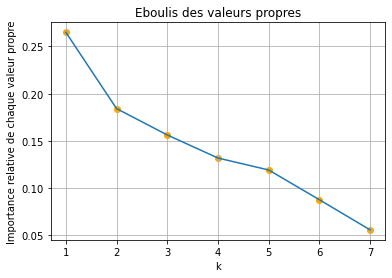

In [11]:
## Scree plot
plt.plot(range(1,8),pca.explained_variance_ratio_);
plt.scatter(range(1,8),pca.explained_variance_ratio_,color='orange');
plt.ylabel("Importance relative de chaque valeur propre")
plt.title("Eboulis des valeurs propres")
plt.xlabel("k")
plt.grid()

In [12]:
## Explained_variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.2650694  0.18422853 0.15629403 0.13184221 0.11918557 0.08766833
 0.05571193]
[0.2650694  0.44929793 0.60559196 0.73743417 0.85661974 0.94428807
 1.        ]


On a une augmentation de variance expliquée de plus de 10% pour un nombre de 3,4, et 5 composantes.  
La variance totale varie entre 60 et 85% pour ce nombre de composantes. Le choix du nombre de composantes s´effectuera grâce à une étude paramétrique, afin d´en évaluer l´impact sur les segmentations realisées.
Le choix final du nombre de composantes est de 3 pour 60% de variance expliquée.

In [13]:
## Decomposition with n components 
pca = decomposition.PCA(n_components=3)
pca_X_scaled = pca.fit(X_scaled)

In [14]:
## Explained variance ratio
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.2650694  0.18422853 0.15629403]
[0.2650694  0.44929793 0.60559196]


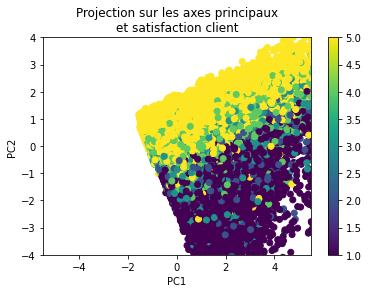

In [15]:
# Projecting X on the principal components space
X_projected = pca.transform(X_scaled)

# Display each observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],

# Coloring along the feature review_score (client satisfaction)
c=data.get('review_score'))

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2');
plt.title('Projection sur les axes principaux\net satisfaction client');

La satisfaction client évolue de manière régulière suivant ces axes.

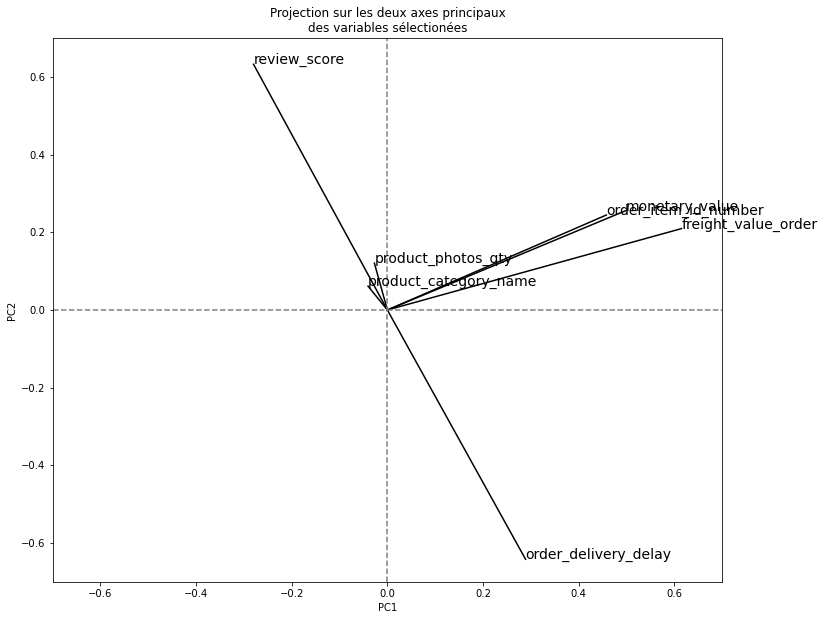

In [16]:
## Displaying each features on the first two components space

pcs = pca.components_
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Display a segment from the origin point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Display the name (data.columns[i]) of the selected feature
    plt.text(x, y, my_data.columns[i], fontsize='14')

# Display a horizontal line  y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Display a vertical line  x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Projection sur les deux axes principaux\ndes variables sélectionées");

## Partition des donneés (decompostion ACP, Kmeans)

On effectue ici une étude paramétrique en croisant:  
- le paramètre nombre de composantes de la reduction ACP 
- le parametre nombre de partitions de l´algorithme Kmeans.  


Cette étude permet de réaliser le choix de segmentation en optimisant le compromis silhouette, nombre de clusters et nombre de composantes de réduction ACP.  

Le choix final effectué s' est porté sur trois segments et trois composantes ACP.

In [17]:
from sklearn.cluster import KMeans

def compute_kmeans(n_cluster,X_projected):
## compute and display clusters , kmeans algorithm

    colors = ['b','g','r','c','m','y','k','w']
    
    ## algorithm kmeans
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', random_state=0)
    kmeans.fit(X_projected)
    kmeans.transform(X_projected)

    ## clusters graphics 
    for labels in np.unique(kmeans.labels_):
        plt.scatter(X_projected[kmeans.labels_==labels,0],
                    X_projected[kmeans.labels_==labels,1],
                    alpha=0.5,
                    label='cluster '+str(labels),color=colors[labels])
        
        plt.scatter(kmeans.cluster_centers_[labels,0],
                    kmeans.cluster_centers_[labels,1],
                    marker='x',
                    color='w')
        
        plt.xlabel('k = '+str(n_cluster))
        plt.axis([-10,15,-10,15])
        plt.rcParams.update({'font.size': 12})
        plt.legend(loc='upper right')
    
    return kmeans.labels_

-  Calcul avec un nombre de composantes ACP de 4 et de clusters de 2,3,4 et 5.

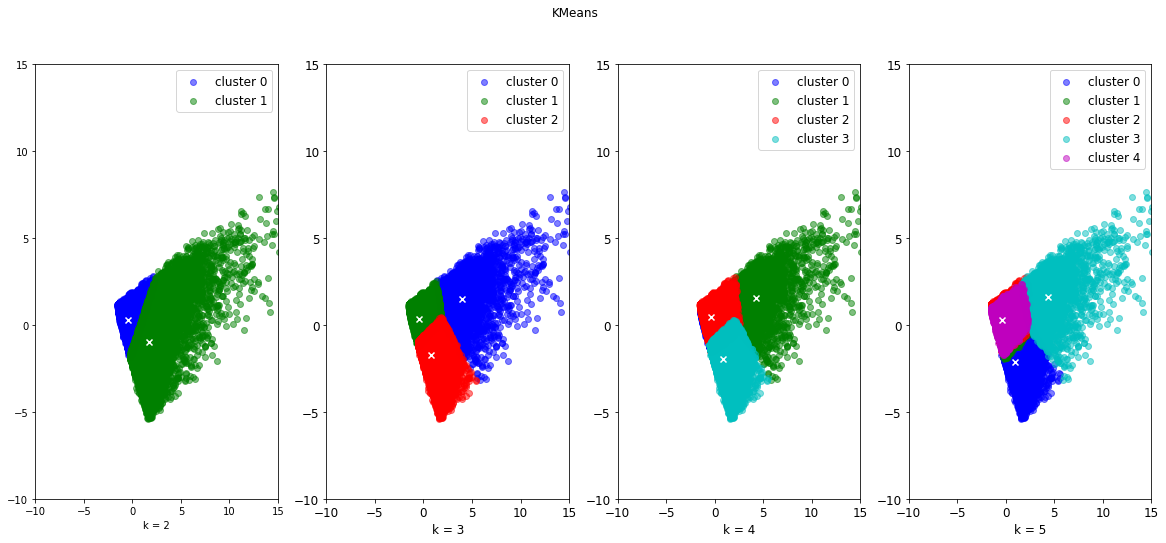

In [18]:
## Decomposition
pca = decomposition.PCA(n_components=4)
pca_X_scaled = pca.fit(X_scaled)

# Projecting X on the principal components space
X_projected = pca.transform(X_scaled)

label = []
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
fig.suptitle('KMeans')

for nb_cluster in range(2,6):
    plt.subplot(1,4,nb_cluster-1)
    label.append(compute_kmeans(nb_cluster,X_projected))

In [19]:
from sklearn.metrics import silhouette_score
silhouette = []
for i in range(len(label)):
    silhouette.append(silhouette_score(X_projected,label[i]))

In [20]:
round(pd.DataFrame(silhouette, index=['k = 2',3,4,5],columns=['Silhouette']),2).T

,k = 2,3,4,5
Silhouette,0.35,0.31,0.28,0.29


-  Calcul avec un nombre de composant ACP de 3 et de clusters de 2,3,4 et 5.

,k = 2,3,4,5
Silhouette,0.42,0.39,0.32,0.33


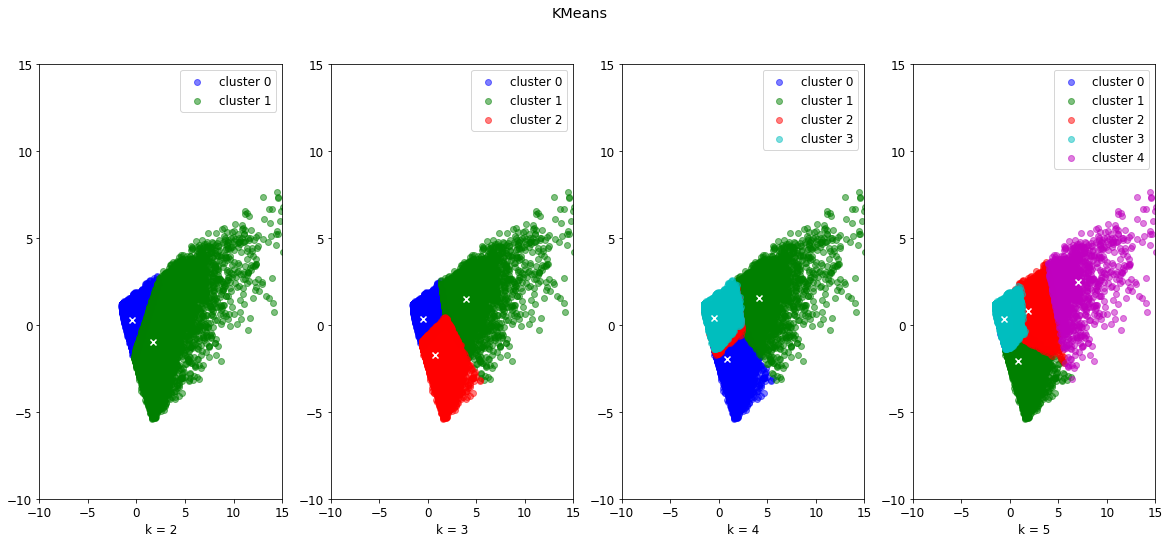

In [21]:
## Decomposition
pca = decomposition.PCA(n_components=3)
pca_X_scaled = pca.fit(X_scaled)

# Projecting X on the principal components space
X_projected = pca.transform(X_scaled)

label = []
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
fig.suptitle('KMeans')

for nb_cluster in range(2,6):
    plt.subplot(1,4,nb_cluster-1)
    label.append(compute_kmeans(nb_cluster,X_projected))

    silhouette = []

for i in range(len(label)):
    silhouette.append(silhouette_score(X_projected,label[i]))
    
round(pd.DataFrame(silhouette, index=['k = 2',3,4,5],columns=['Silhouette']),2).T

-  Calcul avec un nombre de composant ACP de 5 et de clusters de 2,3,4 et 5.

,k = 2,3,4,5
Silhouette,0.35,0.29,0.27,0.26


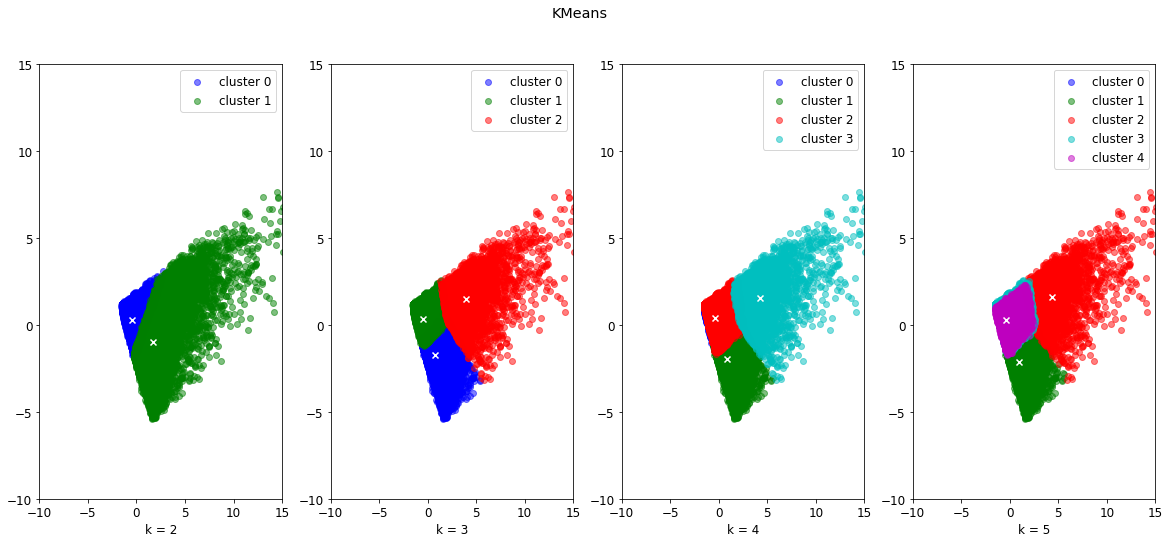

In [22]:
## Decomposition
pca = decomposition.PCA(n_components=5)
pca_X_scaled = pca.fit(X_scaled)

# Projecting X on the principal components space
X_projected = pca.transform(X_scaled)

label = []
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
fig.suptitle('KMeans')

for nb_cluster in range(2,6):
    plt.subplot(1,4,nb_cluster-1)
    label.append(compute_kmeans(nb_cluster,X_projected))

    silhouette = []

for i in range(len(label)):
    silhouette.append(silhouette_score(X_projected,label[i]))
    
round(pd.DataFrame(silhouette, index=['k = 2',3,4,5],columns=['Silhouette']),2).T

**Modèle final**

Le choix effectué est de 3 composantes ACP et 3 segments.  
Il s´agit d´un compromis entre le nombre d´individus dans chaque segment, la silhouette et l' augmentation de variance expliquée

In [23]:
## model selected: Kmeans n_clusters=3, PCA n_components=3
############################################################

## pca decomposition 
pca = decomposition.PCA(n_components=3)
pca_X_scaled = pca.fit(X_scaled)

X_projected = pca.transform(X_scaled)

## kmeans model
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans.fit(X_projected)
label = kmeans.predict(X_projected)

**La segmentation réalisée**

La segmentation finale présente 3 catégories représentant respectivement 75%, 20% et 5% des individus.  
Le panier moyen, le délai de livraison et la satisfaction client sont différenciants .

In [25]:
def segmentation(X, my_data, data, label):
    '''
    Creation of the clustering properties dataframe. 
    '''  
    df_cluster = pd.DataFrame(X,columns=my_data.columns)
    
    df_cluster['label'] = label
    df_cluster['product_category_name'] = data['product_category_name']
    df_cluster['product_photos_qty'] = data['product_photos_qty']
    
    df_cluster_moyenne = round(df_cluster.groupby('label').mean())
    
    df_cluster_cat = \
    df_cluster.groupby('label').agg({
        'product_category_name' : lambda x : x.value_counts().index[0],
        'product_photos_qty' : lambda x : x.value_counts().index[0]
    })

    df_cluster_total = pd.concat([df_cluster_moyenne,df_cluster_cat],axis=1)
    df_proportion = pd.DataFrame( round( 
        100*df_cluster.groupby('label').size()/df_cluster.shape[0] ) ,
                                 columns=['proportion (%)'] )

    return pd.concat([df_cluster_total,df_proportion], axis=1)

In [26]:
segmentation(X, my_data , data, label)

,review_score,order_delivery_delay,freight_value_order,order_item_id_number,monetary_value,product_category_name,product_photos_qty,proportion (%)
label,,,,,,,,
0,5.0,9.0,3.0,1.0,20.0,health_beauty,1,75.0
1,4.0,13.0,12.0,2.0,103.0,furniture_decor,1,5.0
2,2.0,22.0,4.0,1.0,24.0,bed_bath_table,1,20.0


## Maintenabilité

Afin de proposer une durée de maintenance, on s´interesse à une évolution éventuelle du nombre de segments sur une période donnée.  
Ainsi, on évaluera la concordance des segmentations au cours de cette évolution,  la mesure de performance ARI.  


In [27]:
## adjusted_rand_score
from sklearn.metrics import adjusted_rand_score

In [28]:
df = my_data
df['order_purchase_timestamp_M'] = data['order_purchase_timestamp_M']
df['order_purchase_timestamp_Y'] = data['order_purchase_timestamp_Y']

In [31]:
def ARI_clusters_comparison(n_clusters_1,n_clusters_2,df_y_projected):
    '''
    Computation of the adjusted rand score between two clusters
    '''
    kmeans = KMeans(n_clusters=n_clusters_1, init='k-means++', random_state=0)
    kmeans.fit(df_y_projected)
    sample_1 = kmeans.labels_.copy()

    kmeans = KMeans(n_clusters=n_clusters_2, init='k-means++', random_state=0)
    kmeans.fit(df_y_projected)
    sample_2 = kmeans.labels_.copy()

    return adjusted_rand_score(sample_1, sample_2)

In [32]:
## comparison between segmentations,  2018 first semester
## displaying ARI score.

df_y = df[df['order_purchase_timestamp_M'].isin(range(1,7)) & (data['order_purchase_timestamp_Y']==2018)]
 
df_y_transform = std_scale.transform(df_y.iloc[:,:-2].values)
df_y_projected = pca.transform(df_y_transform)    

ari_list=[]
ari_list.append(ARI_clusters_comparison(2,3,df_y_projected))
ari_list.append(ARI_clusters_comparison(3,4,df_y_projected))
ari_list.append(ARI_clusters_comparison(2,4,df_y_projected))

round(pd.DataFrame(ari_list,index=['Clusters evolution 2 -> 3','3 -> 4','2 -> 4'],columns=['ARI']),2)

,ARI
Clusters evolution 2 -> 3,0.78
3 -> 4,0.38
2 -> 4,0.34


## Partition des donneés (décomposition NMF, Kmeans)

La décompostiiton NMF permet de faire émerger distinctement les dimensions sous-jacentes de la segmentation: les variables latentes.

In [33]:
from sklearn.decomposition import NMF

In [34]:
## numerical and categorical features
data_nmf = my_data_ref.copy()
data_nmf['product_category_name'] = raw_data['product_category_name']
data_nmf['product_photos_qty'] = raw_data['product_photos_qty']

X = data_nmf

In [35]:
## NMF model
model = NMF(n_components=4, init='random', random_state=0, max_iter = 1000)
W = model.fit_transform(X)
H = model.components_

In [36]:
round(pd.DataFrame(H,columns=data_nmf.columns),1)

,review_score,order_delivery_delay,freight_value_order,order_item_id_number,monetary_value,product_category_name,product_photos_qty
0,0.4,0.0,1.2,0.2,1.2,0.1,0.1
1,0.0,0.0,0.0,0.0,3.6,0.0,0.0
2,2.7,0.8,0.0,0.5,0.0,53.2,1.2
3,0.4,13.8,0.0,0.2,1.1,0.0,0.4


Variables latentes:  
0 prix et satisfaction, sans le delai de livraison (review_score, freight_value_order, monetary_value)  
1 prix (monetary_value)  
2 produit, satisfaction, nombre de photos (product_category_name, review score, product_photos_qty)    
3 le delai de livraison: (order_delivery_delay)  

**Decomposition NMF et KMeans**

On regarde la partition induite par la décompostion NMF

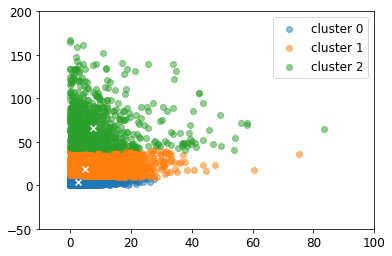

In [37]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans.fit(W)
## clusters non distincts
for labels in np.unique(kmeans.labels_):
    plt.scatter(W[kmeans.labels_==labels,0],W[kmeans.labels_==labels,1],alpha=0.5,label='cluster '+str(labels))
    plt.scatter(kmeans.cluster_centers_[labels,0],kmeans.cluster_centers_[labels,1],marker='x',color='w')
    plt.axis([-10,100,-50,200])
    plt.legend(loc='upper right')

Ici, seul le panier moyen est différenciant.  
Les individus sont majoritairement regroupés dans un segment.

In [38]:
segmentation(X, my_data, data, kmeans.labels_)

,review_score,order_delivery_delay,freight_value_order,order_item_id_number,monetary_value,order_purchase_timestamp_M,order_purchase_timestamp_Y,product_category_name,product_photos_qty,proportion (%)
label,,,,,,,,,,
0,4.0,12.0,3.0,1.0,17.0,NaN,NaN,bed_bath_table,1,89.0
1,4.0,13.0,7.0,1.0,75.0,NaN,NaN,health_beauty,1,10.0
2,4.0,14.0,12.0,1.0,245.0,NaN,NaN,computers,1,1.0


In [39]:
from sklearn.metrics import silhouette_score
round(silhouette_score(W,kmeans.labels_),2) ## clusters distincts sur le panier moyen

0.71

## Partition des donneés (dendrogramme, clustering hiérarchique)

On effectue la même démarche avec l´algorithme de clustering hiérarchique.  
Dans un premier temps, on visualise les données avec un dendrogramme afin de déterminer un nombre de segment au préalable.

**Dendrogramme**

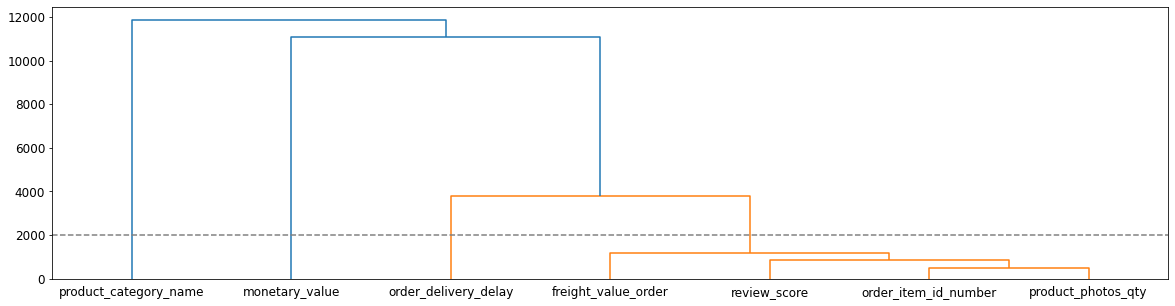

In [40]:
## dendrogram

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
X = my_data.iloc[:,:-2].T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.figure(figsize=(20, 5))
dendrogram(Z,labels = my_data.iloc[:,:-2].columns);
plt.plot([0, 100], [2000, 2000], color='grey', ls='--');

-  Clustering hierarchique (4 clusters), méthode de ward

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
mdl = AgglomerativeClustering(linkage='ward',n_clusters=4,affinity = 'euclidean')

In [43]:

sample = pd.DataFrame(X_projected).sample(frac=1/2).values

mdl.fit(sample)

AgglomerativeClustering(n_clusters=4)

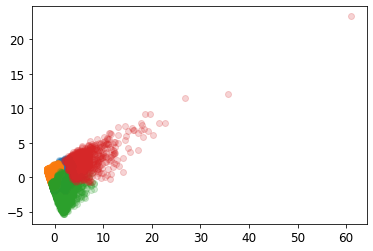

In [44]:
## clusters non distincts
for labels in np.unique(mdl.labels_):
    plt.scatter(sample[mdl.labels_==labels,0],sample[mdl.labels_==labels,1],alpha=0.2)

In [45]:
from sklearn.metrics import silhouette_score
round(silhouette_score(sample,mdl.labels_),2) ## clusters non distincts

0.26

-  Clustering hierarchique (4 clusters), distance

In [46]:
mdl = AgglomerativeClustering(linkage='complete',n_clusters=4,affinity = 'euclidean')

In [47]:
sample = pd.DataFrame(X_projected).sample(frac=1/2).values

mdl.fit(sample)

AgglomerativeClustering(linkage='complete', n_clusters=4)

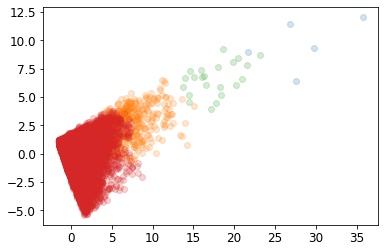

In [48]:
## clusters séparés
for labels in np.unique(mdl.labels_):
    plt.scatter(sample[mdl.labels_==labels,0],sample[mdl.labels_==labels,1],alpha=0.2)

In [49]:
round(silhouette_score(sample,mdl.labels_),2) ## clusters distincts

0.68